In [1]:
import pandas as pd
import datetime
import nltk
nltk.download('punkt')
import unicodedata
import matplotlib.pyplot as plt
import re
from numerize import numerize 

print('Reading file...')
df = pd.read_csv('../out_files/tell_all_corrected.csv')#, nrows=100000
df = df[df['speech'].notna()]

print(df.tail(2))

[nltk_data] Downloading package punkt to /home/dina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Reading file...
                                     member_name sitting_date  \
1280916                                      NaN   24/07/2020   
1280917  κωνσταντινοπουλος κωνσταντινου οδυσσεας   24/07/2020   

        parliamentary_period parliamentary_session parliamentary_sitting  \
1280916   period 18 review 9             session 1           sitting 187   
1280917   period 18 review 9             session 1           sitting 187   

        political_party                                     government  \
1280916           βουλη  ['μητσοτακη κυριακου(08/07/2019-28/07/2020)']   
1280917  κινημα αλλαγης  ['μητσοτακη κυριακου(08/07/2019-28/07/2020)']   

        member_region                                             roles  \
1280916           NaN                                               NaN   
1280917      αρκαδιας  ['ε αντιπροεδρος βουλης(18/07/2019-28/07/2020)']   

        member_gender  speaker_info  \
1280916           NaN  βουλευτης/ες   
1280917          male    προεδρε

In [2]:
from tqdm import tqdm
tqdm.pandas()

df = df.rename(columns={'parliamentary_period': 'period'})

df.period = df.period.apply(lambda x: x.replace(' review 9',''))
df.period = df.period.apply(lambda x: x.replace('period ',''))

df.period = df.period.astype(int)

print(datetime.datetime.now())

#Group speeches by period
PERperiod_df_original = df.groupby(df.period)['speech'].progress_apply(' '.join).reset_index()

print(datetime.datetime.now())

2021-07-11 10:05:11.864772


100%|██████████| 14/14 [00:00<00:00, 31.11it/s]

2021-07-11 10:05:12.325392


In [3]:
def periods_to_dates(periods):

    period_dict = {5:'7/1989-10/1989',
                  6:'11/1989-3/1990',
                  7:'4/1990-9/1993',
                  8:'10/1993-8/1996',
                  9:'10/1996-3/2000',
                  10:'4/2000-2/2004',
                  11:'3/2004-8/2007',
                  12:'9/2007-9/2009',
                  13:'10/2009-4/2012',
                  14:'5/2012-5/2012', 
                  15:'6/2012-12/2014', 
                  16:'2/2015-8/2015',
                  17:'10/2015-6/2019', 
                  18:'7/2019-7/2020'}
    
    if isinstance(periods, list):
        out = period_dict[periods[0]]+' & '+period_dict[periods[1]]
        return out 
    else:
        return 'Period '+str(periods)+'\n'+period_dict[periods]        

def step_one_pairs(list_of_items):
    return [(list_of_items[i],list_of_items[i+1]) for i in range(len(list_of_items)-1)]


In [4]:
# Sort periods based on number in the string

periods = sorted(PERperiod_df_original.period.to_list())
period_pairs = step_one_pairs(periods)
print(period_pairs)

[(5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18)]


In [5]:
PERperiod_df_original['vocab'] = PERperiod_df_original.speech.progress_apply(lambda x: nltk.word_tokenize(x.lower()))

100%|██████████| 14/14 [12:38<00:00, 54.20s/it]


In [6]:
common_vocab = []

for pair in period_pairs:
    
    s1 = set(PERperiod_df_original.loc[(PERperiod_df_original.period==pair[0])].vocab.values[0])
    s2 = set(PERperiod_df_original.loc[(PERperiod_df_original.period==pair[1])].vocab.values[0])
    common_voc = len(s1.intersection(s2))
    common_vocab.append([pair, common_voc])
    
common_vocab_original = pd.DataFrame(common_vocab, columns = ['pair', 'common_vocab'])
print(common_vocab_original.head(2))

     pair  common_vocab
0  (5, 6)         30043
1  (6, 7)         46959


[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[(5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18)]
[5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5]


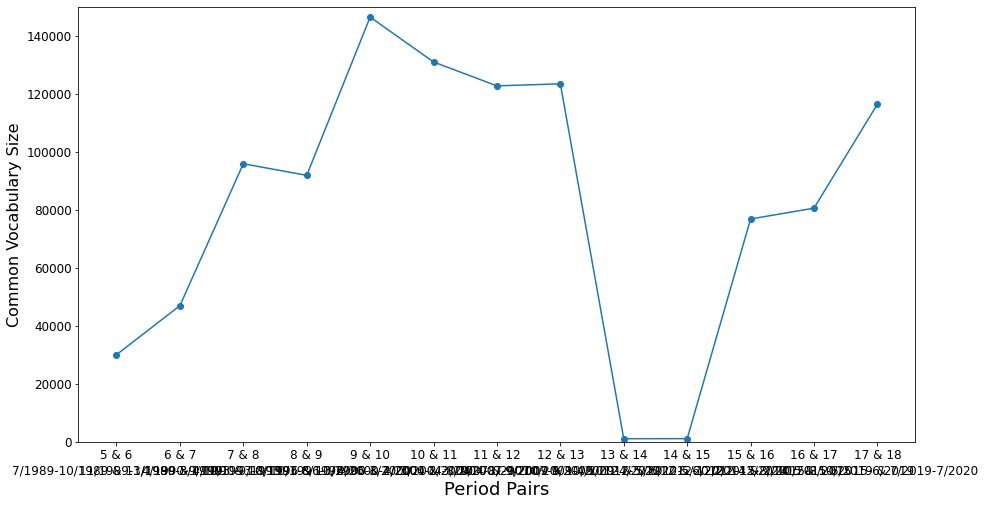

<Figure size 432x288 with 0 Axes>

In [7]:
from matplotlib.font_manager import FontProperties
import random
import matplotlib.pyplot as plt
import seaborn as sns


periods = sorted(PERperiod_df_original.period.to_list())
print(periods)

period_pairs = step_one_pairs(periods)
print(period_pairs)

fig = plt.figure(figsize=(15, 8))
colors = sns.color_palette("hls", 90) #90 is available pairs

plt.rcParams.update({'font.size': 12})

X = common_vocab_original.pair.to_list()
Y = common_vocab_original.common_vocab.to_list()
X = [i+0.5 for i in range(periods[0], periods[-1])]
print(X)
plt.scatter(X,Y)

plt.plot(X,Y)
plt.xticks([i+0.5 for i in range(periods[0], periods[-1])], [
    (str(i)+' & '+str(i+1)+'\n'+periods_to_dates([i,i+1])) for i in range(periods[0], periods[-1])])

plt.xlabel('Period Pairs', fontsize=18)
plt.ylabel('Common Vocabulary Size', fontsize=16)

ax = plt.gca()
ax.set_ylim([0,150000])
handles, labels = ax.get_legend_handles_labels()
plt.savefig('../out_files/common_periodic_vocab_before.png', dpi=200,  bbox_inches='tight')

plt.show()
plt.cla()
plt.clf()
fig.clear()
plt.close(fig)
